# HALHF Transverse Wake Instability Stages (Slice Version) Tests

For simulating the HALHF linac with interstages. The simulation employs the slice version of transverse wake instability model.

Ben Chen, 7 September 2023, University of Oslo

## Import ABEL framework and required classes

In [1]:
import sys
sys.path.append('../')
from abel import *
import numpy as np

from scipy.constants import c, e, m_e, epsilon_0 as eps0
from abel.utilities.relativity import energy2gamma

# Enable the widget backend for interactive plots
%matplotlib widget

# Sets the seed for the pseudo-random number generator in Python to obtain the same sequence of random numbers.
np.random.seed(42) 

## Settings and definitions

In [2]:
# Determines whether the results of the tracking should be overwritten.
overwrite = False

# Determines whether to use interstages in the tracking. Currently also need to comment out some lines in interstage_basic.py.
use_interstages = True

# Specifies the region of interest in units of main beam sigma_z (rms bunch length).
main_beam_roi = 3.0

# Number of stages in the linac.
num_stages = 16

# Set the default DPI
plt.rcParams['figure.dpi'] = 100

# Set the figure size to fit within the notebook cell
#plt.rcParams['figure.figsize'] = [.1, .1]  # Adjust these values as needed

# Set various paths
notebook_name = 'HALHF_slice_instability_stage_tests'
path_sep = os.sep
#upload_dir = '/scratch/project_465000445/jianbinb/uploaded/'
current_dir = os.path.abspath('')  # Get the current file's directory name.

# Labels for plots
zlab = '$z$ [$\mathrm{\mu}$m]'
xilab = r'$\xi$ [$\mathrm{\mu}$m]'
slab = '$s$ [m]'
xlab = '$x$ [$\mathrm{\mu}$m]'
field_lab = '$E_z$ [GV/m]'
dN_dz_lab = '$\partial N/\partial z$ [$\mathrm{m}^{-1}$]'
xps_lab = '$x\'$ [mrad]'
energ_lab = '$\mathcal{E}$ [GeV]'

## Define the input beams
Parameters based on "A hybrid, asymmetric, linear Higgs factory based on plasma-wakefield and radio-frequency acceleration" 23 Aug 2023.

In [3]:
# Define drive beam
driver = SourceBasic()
driver.num_particles = 50000
driver.charge = -e * 2.7e10  # [C]
driver.energy = 31.25e9  # [eV]
driver_gamma = energy2gamma(driver.energy)
driver.rel_energy_spread = 0.01*0
driver.bunch_length = 42.0e-6  # [m]
driver.z_offset = 334.0e-6  # [m]
driver.emit_nx, driver.emit_ny = 10.0e-6, 10.0e-6  # [m rad]
driver.beta_x, driver.beta_y = 30.0e-3, 30.0e-3 # [m]
#driver.wallplug_efficiency = 0.19

# Define main beam
main = SourceBasic()
main.num_particles = int(50000*2)
main.charge = -e * 1.0e10  # [C]
main.energy = 5e9  # [eV]
main_gamma = energy2gamma(main.energy)
main.rel_energy_spread = 0.005  # Relative rms energy spread.
main.bunch_length = 18.0e-06  # [m]
main.emit_nx, main.emit_ny = 160.0e-6, 0.56e-6  # [m rad]
main.beta_x = beta_matched(7.0e21, main.energy)  # [m]
main.beta_y = beta_matched(7.0e21, main.energy)  # [m]
main_sigma_x = np.sqrt(main.emit_nx/main_gamma*main.beta_x)  # [m]
main_sigma_y = np.sqrt(main.emit_ny/main_gamma*main.beta_y)  # [m]
main.x_offset = main_sigma_x*0.1  # [m]
main.y_offset = main_sigma_y*0.1  # [m]
#main.z_offset = 0.0  # [m]
main.z_offset = 9.7e-6  # [m]
main.symmetrize = True
#main.wallplug_efficiency = 0.1
#main.accel_gradient = 6.4e9  # [V/m]

## Define the linac

/Users/ben_c/Library/CloudStorage/OneDrive-UniversitetetiOslo/Software/opal_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ben_c/Library/CloudStorage/OneDrive-UniversitetetiOslo/Software/opal_env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


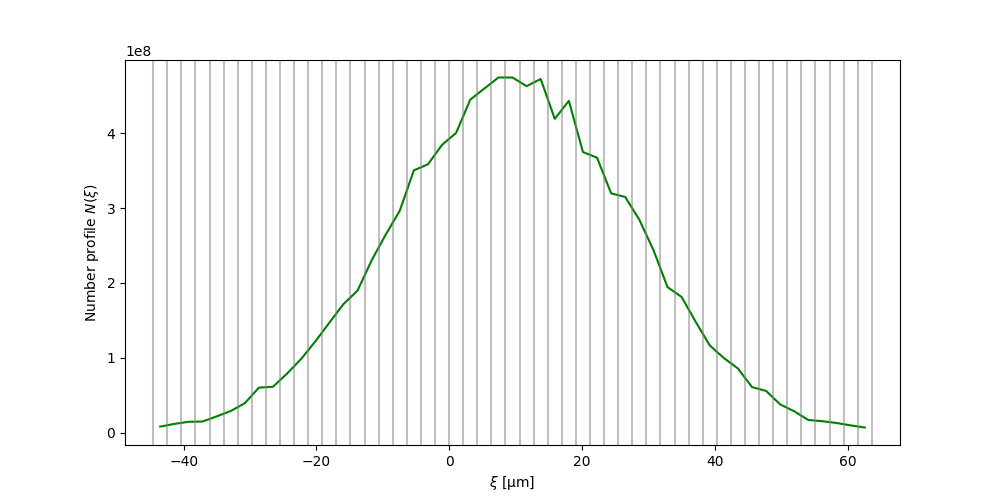

In [4]:
############# Define the first stage #############
first_stage = StageSlicesTransWakeInstability()
first_stage.length = 2.5  # [m]
first_stage.nom_energy_gain = 6.4e9*first_stage.length  # [eV]
first_stage.plasma_density = 7.0e21  # [m^-3]
first_stage.driver_source = driver
first_stage.main_source = main
drive_beam = first_stage.driver_source.track()  # Convert a Source object to a Beam object.
main_beam = first_stage.main_source.track()  # Convert a Source object to a Beam object.
first_stage.drive_beam = drive_beam
first_stage.main_beam = main_beam
first_stage.diag_path = current_dir + path_sep + 'run_data' + path_sep + notebook_name + path_sep


# ========== Beam slice parameters ========== 
first_stage.main_beam_roi = main_beam_roi
cut_off = first_stage.main_beam_roi*main.bunch_length
first_stage.beam_length_roi = 2*cut_off  # [m] total bunch/beam length.  old name: tot_beam_length

# Option: manually determine the beam slice thickness
beam_slice_thickness = 0.0196*first_stage.beam_length_roi   # [m] thickness of each beam slice.
num_uniform_beam_slice = int(np.round(first_stage.beam_length_roi / beam_slice_thickness))

# Option: sqrt rule for determining the beam slice thickness
#z0s_main = main_beam.zs()
#bool_indices = (z0s_main <= np.mean(z0s_main) + cut_off) & (z0s_main >= np.mean(z0s_main) - cut_off)
#z0s_filtered = z0s_main[bool_indices]
#num_uniform_beam_slice = int(np.sqrt(len(z0s_filtered)/2))

# Option: Freedman–Diaconis rule for determining the beam slice thickness
#num_uniform_beam_slice = first_stage.FD_rule_num_slice()

first_stage.num_uniform_beam_slice = num_uniform_beam_slice

# Number profile N(z). Dimensionless, same as dN/dz with each bin multiplied with the width of the slices.
main_num_profile, z0s_main_cut = first_stage.longitudinal_number_distribution(beam=first_stage.main_beam, uniform_bins=True, make_plot=True)  # uniform_bins=False allows for thicker slices towards beam head.
first_stage.main_num_profile = main_num_profile
first_stage.zs_main_cut = z0s_main_cut
num_beam_slice = len(z0s_main_cut)
first_stage.num_beam_slice = num_beam_slice

driver_num_profile, zs_driver_cut = first_stage.longitudinal_number_distribution(beam=first_stage.drive_beam, uniform_bins=True)
first_stage.driver_num_profile = driver_num_profile
first_stage.zs_driver_cut = zs_driver_cut

# Initial main beam slice x-offsets, energies and x'-offsets
first_stage.x_slices_main = first_stage.particles2slices(beam=first_stage.main_beam, beam_quant=first_stage.main_beam.xs(), z_slices=first_stage.zs_main_cut, make_plot=False)
first_stage.xp_slices_main = first_stage.particles2slices(beam=first_stage.main_beam, beam_quant=first_stage.main_beam.xps(), z_slices=first_stage.zs_main_cut, make_plot=False)
first_stage.y_slices_main = first_stage.particles2slices(beam=first_stage.main_beam, beam_quant=first_stage.main_beam.ys(), z_slices=first_stage.zs_main_cut, make_plot=False)
first_stage.yp_slices_main = first_stage.particles2slices(beam=first_stage.main_beam, beam_quant=first_stage.main_beam.yps(), z_slices=first_stage.zs_main_cut, make_plot=False)
first_stage.energy_slices_main = first_stage.particles2slices(beam=first_stage.main_beam, beam_quant=first_stage.main_beam.Es(), z_slices=first_stage.zs_main_cut, make_plot=False)



############# Define the other stages #############
stage = StageSlicesTransWakeInstability()
stage.length = 5.0  # [m]
stage.nom_energy_gain = 500.0e9/16  # [eV]
stage.plasma_density = 7.0e21  # [m^-3]
stage.driver_source = driver
stage.main_source = main
stage.drive_beam = drive_beam
stage.main_beam = main_beam
stage.diag_path = current_dir + path_sep + 'run_data' + path_sep + notebook_name + path_sep


# ========== Beam slice parameters ==========
stage.main_beam_roi = main_beam_roi  # Specifies the region of interest in units of main beam sigma_z (rms bunch length).
cut_off = stage.main_beam_roi*main.bunch_length
stage.beam_length_roi = 2*cut_off  # [m] total bunch/beam length.  old name: tot_beam_length
stage.num_uniform_beam_slice = num_uniform_beam_slice
stage.num_beam_slice = num_beam_slice

# Number profile N(z). Dimensionless, same as dN/dz with each bin multiplied with the width of the slices.
stage.main_num_profile = main_num_profile
stage.zs_main_cut = z0s_main_cut
driver_num_profile, zs_driver_cut = stage.longitudinal_number_distribution(beam=stage.drive_beam)
stage.driver_num_profile = driver_num_profile
stage.zs_driver_cut = zs_driver_cut

# Initial main beam slice x-offsets, energies and x'-offsets
stage.x_slices_main = first_stage.x_slices_main
stage.xp_slices_main = first_stage.xp_slices_main
stage.y_slices_main = first_stage.y_slices_main
stage.yp_slices_main = first_stage.yp_slices_main
stage.energy_slices_main = first_stage.energy_slices_main



############# Define interstages #############
if use_interstages is True:
    interstage = InterstageBasic()
    interstage.beta0 = lambda energy: stage.matched_beta_function(energy)
    interstage.dipole_length = lambda energy: 1 * np.sqrt(energy/10e9)  # [m(eV)], energy-dependent length
    interstage.dipole_field = 0.5 # [T]  (0-2)T
else:
    interstage = InterstageNull()



############# Define linac #############
linac = Linac(source=main, first_stage=first_stage, stage=stage, interstage=interstage, num_stages=num_stages)

In [5]:
first_stage.print_initial_summary(drive_beam, main_beam)

Plasma density [m^-3]:					 7.000e+21
Mean initial gamma:					 9784.460
Mean initial energy [GeV]:				 5.000
Initial rms energy spread [%]:				 0.502

rms beam length [um]:					 18.067
Beam region of interest [sigma_z]:			 3.000
Beam slice thickness [um]:				 2.118
Number of beam slices:					 51
Number of beam particles:				 100000

Initial drive beam x offset [um]:			 -0.001
Initial drive beam y offset [um]:			 0.008
Initial drive beam z offset [um]:			 333.889

Initial main beam x offset [um]:			 1.205
Initial main beam y offset [um]:			 0.071
Initial main beam z offset [um]:			 9.607

Initial normalised x emittance [mm mrad]:		 160.637
Initial normalised y emittance [mm mrad]:		 0.561

Initial matched beta function [mm]:			 8.885
Initial x beta function [mm]:				 8.917
Initial y beta function [mm]:				 8.880

Initial x beam size [um]:				 12.099
Initial y beam size [um]:				 0.714
----------------------------------------------------------------------


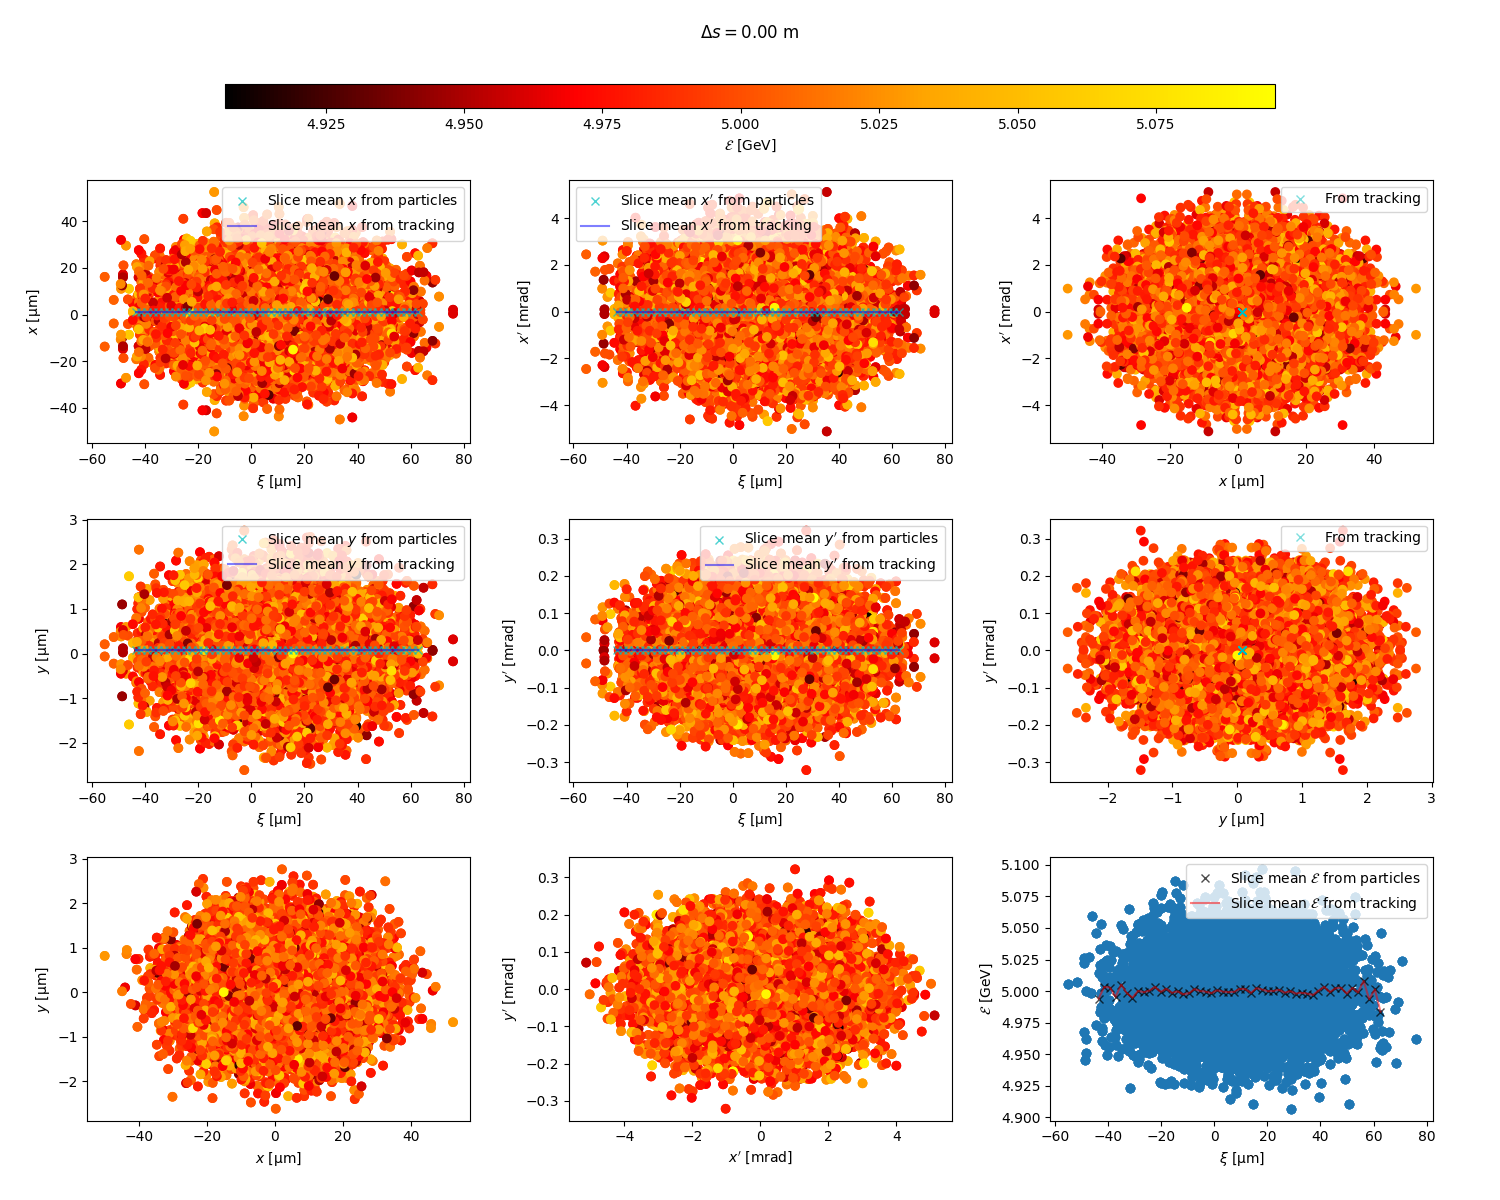

In [6]:
first_stage.scatter_diags(beam=first_stage.main_beam, plot_centroids=True, n_th_particle=2)

## Calculate input longitudinal field, plasma bubble radius and longitudinal number profile with Wake-T

In [7]:
# Define a Wake-T stage
stage_wakeT = StageWakeT()
stage_wakeT.driver_source = driver
k_beta = k_p(stage.plasma_density)/np.sqrt(2*min(main_beam.gamma(),drive_beam.gamma()/2))
lambda_betatron = (2*np.pi/k_beta)
stage_wakeT.length = lambda_betatron/10  # [m]
stage_wakeT.plasma_density = stage.plasma_density  # [m^-3]
#stage_wakeT.keep_data = True

# Run the Wake-T stage
beam_copy = copy.deepcopy(main_beam)
beam_wakeT = stage_wakeT.track(beam_copy)

Plasma stage: 100%|███████████████████████████████████████████| 0.005583/0.005583 m [00:00]


### Extract data

In [8]:
# Extract initial beam densities
beams_dens = stage_wakeT.initial.beam.density.rho
beams_extent = stage_wakeT.initial.beam.density.extent

# Extract transverse fields
Ex = stage_wakeT.initial.plasma.wakefield.Exs
By = stage_wakeT.initial.plasma.wakefield.Bys
info_Ex = stage_wakeT.initial.plasma.wakefield.Exs_metadata
Ex_cBy = Ex - c*By
zs_Ex = info_Ex.z
rs_Ex = info_Ex.r

# Extract longitudinal E-field
Ez_wakeT = stage_wakeT.initial.plasma.wakefield.Ezs
info_Ez = stage_wakeT.initial.plasma.wakefield.Ezs_metadata
zs_Ez_wakeT = info_Ez.z
rs_Ez = info_Ez.r

# Extract axial longitudinal E-field
Ez_axis_wakeT = stage_wakeT.initial.plasma.wakefield.onaxis.Ezs
zs_Ez_wakeT = stage_wakeT.initial.plasma.wakefield.onaxis.zs

# Extract plasma charge density
rho = stage_wakeT.initial.plasma.density.rho
info_rho = stage_wakeT.initial.plasma.density.metadata

# Calculate the number density
plasma_num_density = rho/stage_wakeT.plasma_density
# Extract coordinates
zs_rho = info_rho.z
rs_rho = info_rho.r

# Extract the plasma bubble radius
#bubble_radius_wakeT = first_stage.get_bubble_radius(plasma_num_density, rs_rho, main_offset=main_beam.x_offset(), threshold=0.8)
bubble_radius_wakeT = first_stage.get_bubble_radius(plasma_num_density, rs_rho, threshold=0.8)

# Extract number density profiles for drive and main beam
zs_dNdz = stage_wakeT.initial.beam.current.zs
dNdz = stage_wakeT.initial.beam.current.Is/-e/c

### Make plots

Text(0, 0.5, '$\\partial N/\\partial z$ [$\\mathrm{m}^{-1}$]')

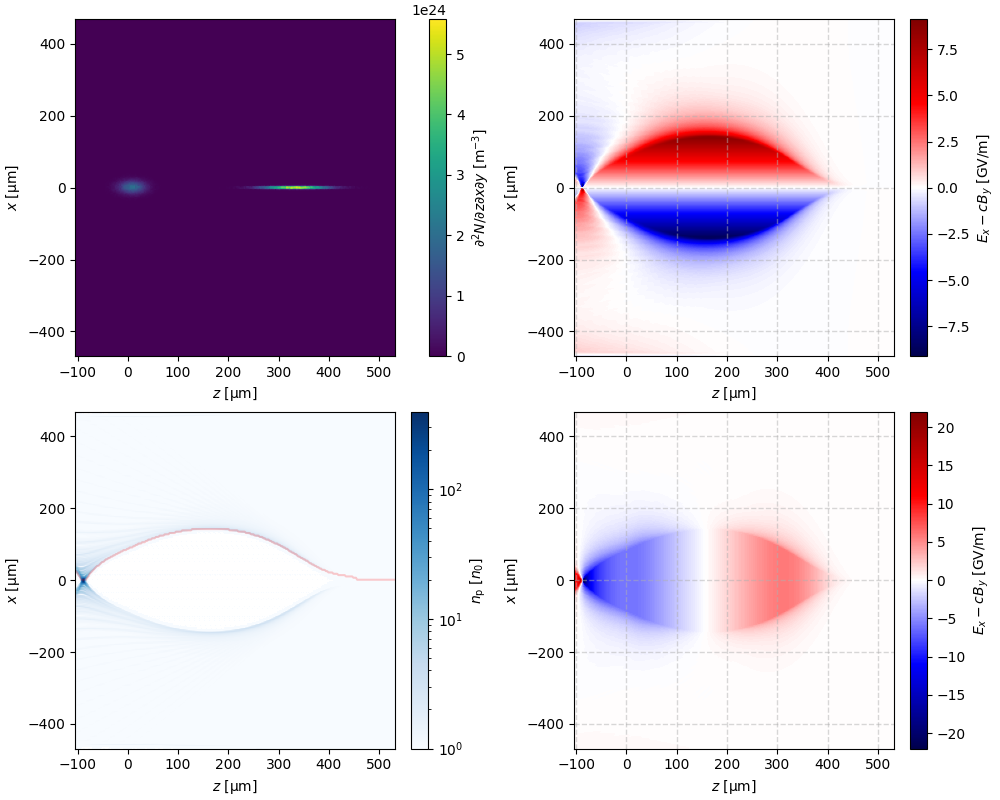

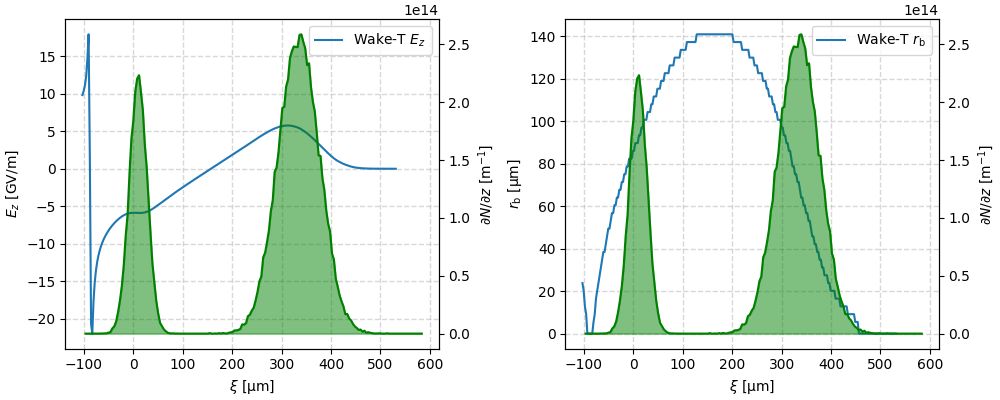

In [9]:
# Labels for plots
zlab = '$z$ [$\mathrm{\mu}$m]'
xilab = r'$\xi$ [$\mathrm{\mu}$m]'
xlab = '$x$ [$\mathrm{\mu}$m]'
field_lab = '$E_z$ [GV/m]'
dN_dz_lab = '$\partial N/\partial z$ [$\mathrm{m}^{-1}$]'

# Set up a figure with axes
fig_wakeT, axs_wakeT = plt.subplots(nrows=2, ncols=2, layout="constrained", figsize=(10, 4*2))

# Plot the bunches
first_stage.imshow_plot(beams_dens, axes=axs_wakeT[0][0], extent=beams_extent*1e6, colmap='viridis', xlab=zlab, ylab=xlab, clab='$\partial^3 N/\partial z\partial x\partial y$ [$\mathrm{m}^{-3}$]', gridOn=False, origin='lower', log_cax=False)

# Plot the transverse fields
Ex_extent = stage_wakeT.initial.plasma.wakefield.Exs_metadata.imshow_extent*1e6
first_stage.imshow_plot(Ex_cBy/1e9, axes=axs_wakeT[0][1], extent=Ex_extent, vmin=Ex_cBy.min()/1e9, vmax=-Ex_cBy.min()/1e9, colmap='seismic', xlab=zlab, ylab=xlab, clab='$E_x-cB_y$ [GV/m]', gridOn=True, origin='lower')

# Plot the plasma number density
rho_extent = stage_wakeT.initial.plasma.density.extent*1e6
first_stage.imshow_plot(plasma_num_density, axes=axs_wakeT[1][0], extent=rho_extent, colmap='Blues', xlab=zlab, ylab=xlab, clab='$n_\mathrm{p}$ [$n_0$]', gridOn=False, origin='lower', log_cax=True)
axs_wakeT[1][0].plot(zs_rho*1e6, (bubble_radius_wakeT+main.x_offset)*1e6, 'r', alpha=0.2)

# Plot the longitudinal electric field
Ez_extent = stage_wakeT.initial.plasma.wakefield.Ezs_metadata.imshow_extent*1e6
first_stage.imshow_plot(Ez_wakeT/1e9, axes=axs_wakeT[1][1], extent=Ez_extent, vmin=Ez_wakeT.min()/1e9, vmax=-Ez_wakeT.min()/1e9, colmap='seismic', xlab=zlab, ylab=xlab, clab='$E_x-cB_y$ [GV/m]', gridOn=True, origin='lower')

# Set up a figure with axes
fig_wakeT2, axs_wakeT2 = plt.subplots(nrows=1, ncols=2, layout="compressed", figsize=(10, 4))
#fig_wakeT2.suptitle('$t=$' f'{format(dump_time, ".2e")}' ' s')

# Plot longitudinal axial E-field
axs_wakeT2[0].plot(zs_Ez_wakeT*1e6, Ez_axis_wakeT/1e9, label='Wake-T $E_z$')
axs_wakeT2[0].legend()
axs_wakeT2[0].grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=.5)
axs_wakeT2[0].set_xlabel(xilab)
axs_wakeT2[0].set_ylabel(field_lab)
ax = axs_wakeT2[0].twinx()
ax.fill_between(x=zs_dNdz*1e6, y1=dNdz , y2=0, color='g', alpha=0.5)
ax.plot(zs_dNdz*1e6, dNdz, 'g')
ax.set_ylabel(dN_dz_lab)

# Plot the plasma bubble radius
axs_wakeT2[1].plot((zs_rho)*1e6, bubble_radius_wakeT*1e6, label='Wake-T $r_\mathrm{b}$')
axs_wakeT2[1].legend()
axs_wakeT2[1].grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=.5)
axs_wakeT2[1].set_xlabel(xilab)
axs_wakeT2[1].set_ylabel('$r_\mathrm{b}$ [$\mathrm{\mu}$m]')
ax = axs_wakeT2[1].twinx()
ax.fill_between(x=zs_dNdz*1e6, y1=dNdz , y2=0, color='g', alpha=0.5)
ax.plot(zs_dNdz*1e6, dNdz, 'g')
ax.set_ylabel(dN_dz_lab)


#stage_wakeT.plot_evolution()
#beam_wakeT.plot_lps()

## Perform tracking

In [10]:
linac.run(notebook_name, overwrite=overwrite)

Tracking element 1 (SourceBasic, stage 0, s = 0.0 m, 5.0 GeV, -1.60 nC, 0.5% rms, 160.1/0.6 µm-rad)
Plasma stage: 100%|███████████████████████████████████████████| 0.005583/0.005583 m [00:00]


/Users/ben_c/Library/CloudStorage/OneDrive-UniversitetetiOslo/ABEL/examples/../abel/classes/stage/impl/stage_slice_transverse_wake_instability.py:311: RuntimeWarning: invalid value encountered in divide
  xp_slices_start = ux_slices_after*uz_slices_before/ux_slices_before/uz_slices_after * xp_slices_start ################
/Users/ben_c/Library/CloudStorage/OneDrive-UniversitetetiOslo/ABEL/examples/../abel/classes/stage/impl/stage_slice_transverse_wake_instability.py:312: RuntimeWarning: invalid value encountered in divide
  yp_slices_start = uy_slices_after*uz_slices_before/uy_slices_before/uz_slices_after * yp_slices_start ################
/Users/ben_c/Library/CloudStorage/OneDrive-UniversitetetiOslo/ABEL/examples/../abel/classes/stage/impl/stage_slice_transverse_wake_instability.py:318: RuntimeWarning: invalid value encountered in divide
  xp_slices = ux_slices_after*uz_slices_before/ux_slices_before/uz_slices_after * xp_slices
/Users/ben_c/Library/CloudStorage/OneDrive-Universiteteti

Tracking element 2 (StageSlicesTransWakeInstability, stage 1, s = 2.5 m, 19.6 GeV, -1.60 nC, 3.9% rms, 168.4/0.6 µm-rad)
Tracking element 3 (InterstageBasic, stage 1, s = 9.4 m, 19.6 GeV, -1.60 nC, 3.9% rms, 168.7/0.6 µm-rad)
Plasma stage: 100%|███████████████████████████████████████████| 0.009869/0.009869 m [00:00]
Tracking element 4 (StageSlicesTransWakeInstability, stage 2, s = 14.4 m, 49.7 GeV, -1.60 nC, 3.4% rms, 173.1/0.6 µm-rad)
Tracking element 5 (InterstageBasic, stage 2, s = 25.4 m, 49.7 GeV, -1.60 nC, 3.4% rms, 173.1/0.6 µm-rad)
Plasma stage: 100%|███████████████████████████████████████████| 0.009869/0.009869 m [00:00]
Tracking element 6 (StageSlicesTransWakeInstability, stage 3, s = 30.4 m, 80.2 GeV, -1.60 nC, 2.9% rms, 181.3/0.6 µm-rad)
Tracking element 7 (InterstageBasic, stage 3, s = 44.2 m, 80.2 GeV, -1.60 nC, 2.9% rms, 181.3/0.6 µm-rad)
Plasma stage: 100%|███████████████████████████████████████████| 0.009869/0.009869 m [00:00]
Tracking element 8 (StageSlicesTransWakeIn

In [21]:
shot_num = 0
stage_num = 15
stage_tracked = linac[shot_num].stages[stage_num]  # Get a specific acceleration stage in a linac. Zero indexing.
beam_out = linac[shot_num].get_beam(stage_num*2+1)  # Get the corresponding beam after the acceleration stage. Zero indexing.

stage_tracked.print_current_summary(drive_beam, main_beam, beam_out)

Stage length [m]:					 5.000
Propagation length [m]:					 410.826
Plasma density [m^-3]:					 7.000e+21
Current mean gamma:					 956642.679
Current mean energy  [GeV]:				 488.843
Initial rms energy spread [%]:				 0.502
Current rms energy spread [%]:				 0.469

Current rms main beam length [um]:			 13.802
Initial rms main beam length [um]:			 18.067
Beam region of interest [sigma_z]:			 3.000
Beam slice thickness [um]:				 2.118
Number of beam slices:					 47
Initial number of beam particles:			 100000
Current number of beam particles:			 100000

Initial drive beam x offset [um]:			 -0.001
Initial drive beam y offset [um]:			 0.008
Initial drive beam z offset [um]:			 333.889

Initial main beam x offset [um]:			 1.205
Initial main beam y offset [um]:			 0.071
Initial main beam z offset [um]:			 9.607

Initial normalised x emittance [mm mrad]:		 160.637
Current normalised x emittance [mm mrad]:		 386.946
Initial normalised y emittance [mm mrad]:		 0.561
Current normalised y emittance [

## Plot outputs

### Cut-out bubble radius, longitudinal E-field and longitudinal beam profile

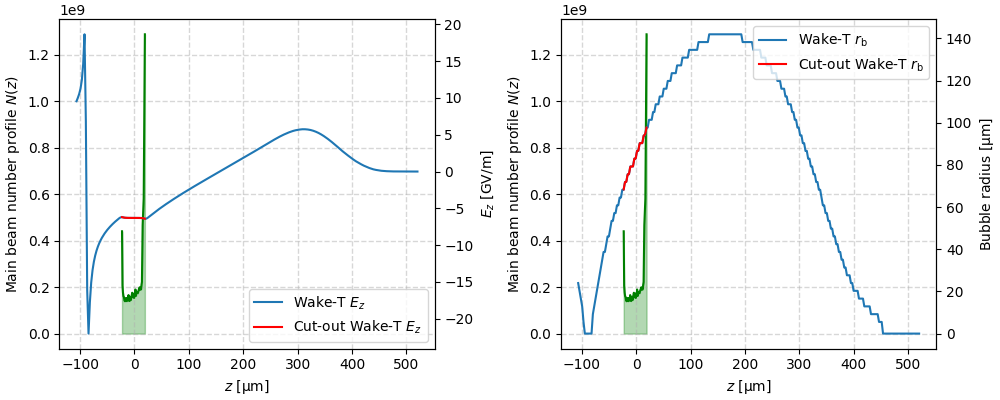

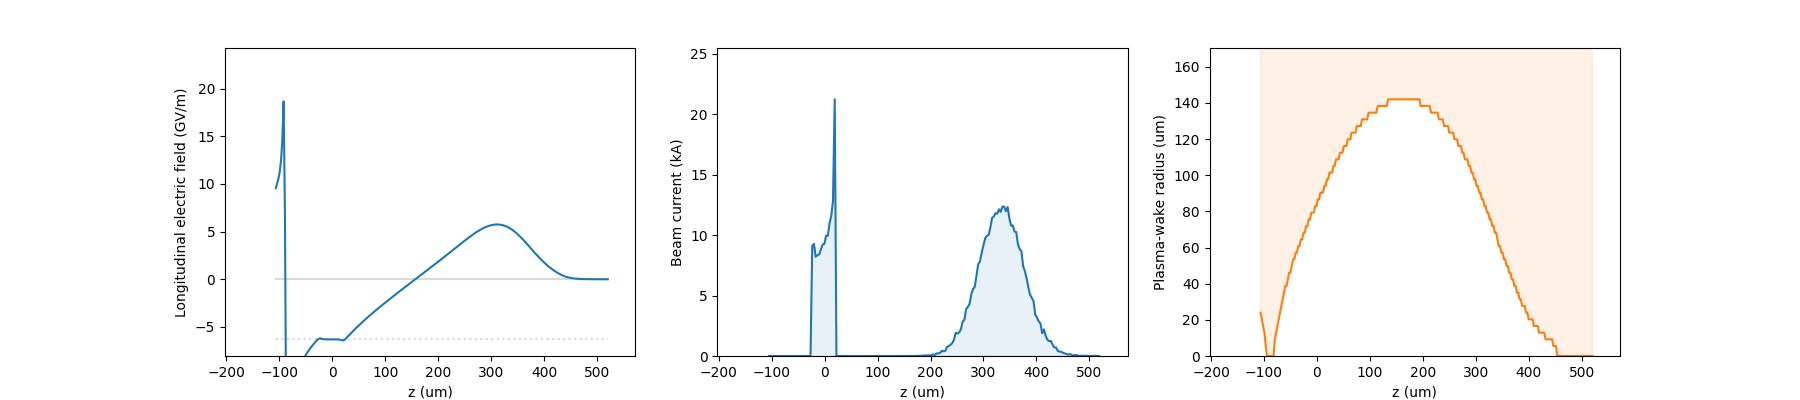

In [12]:
stage_tracked.plot_Ez_rb_cut()

stage_tracked.plot_wakefield(beam=beam_out)

### Beam slice plots

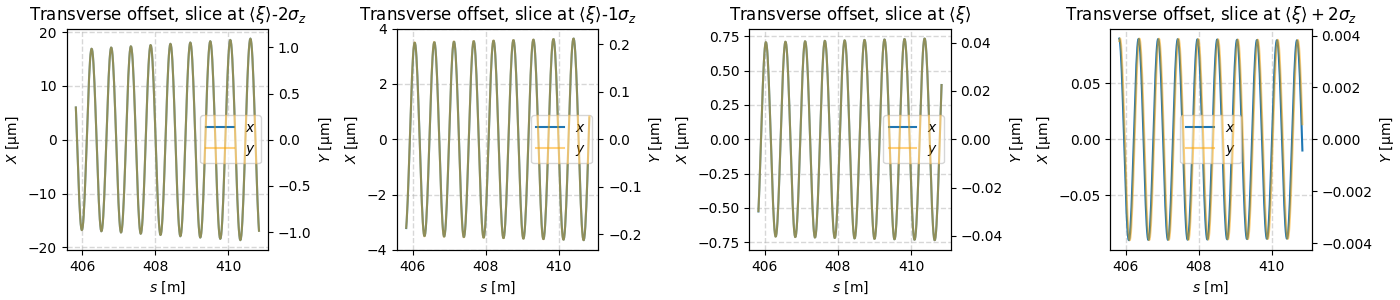

In [13]:
stage_tracked.slice_offset_s_diag(beam=beam_out)

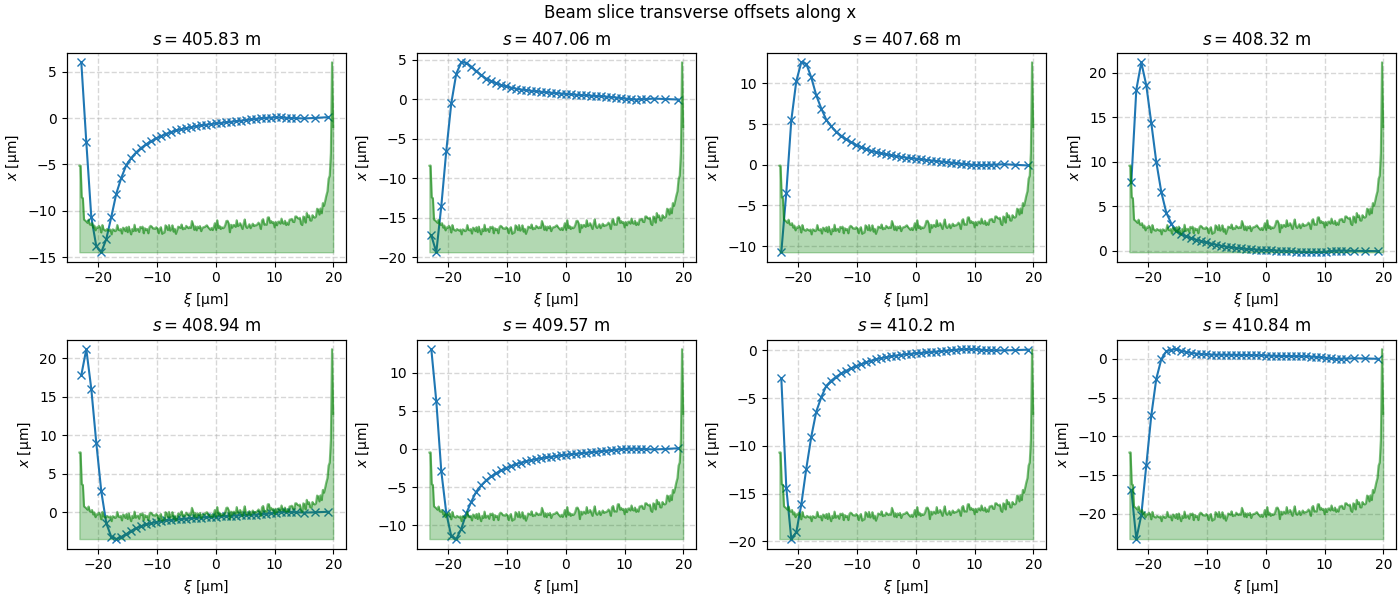

In [14]:
stage_tracked.centroid_snapshot_plots(beam=beam_out)

### Beam particle plots

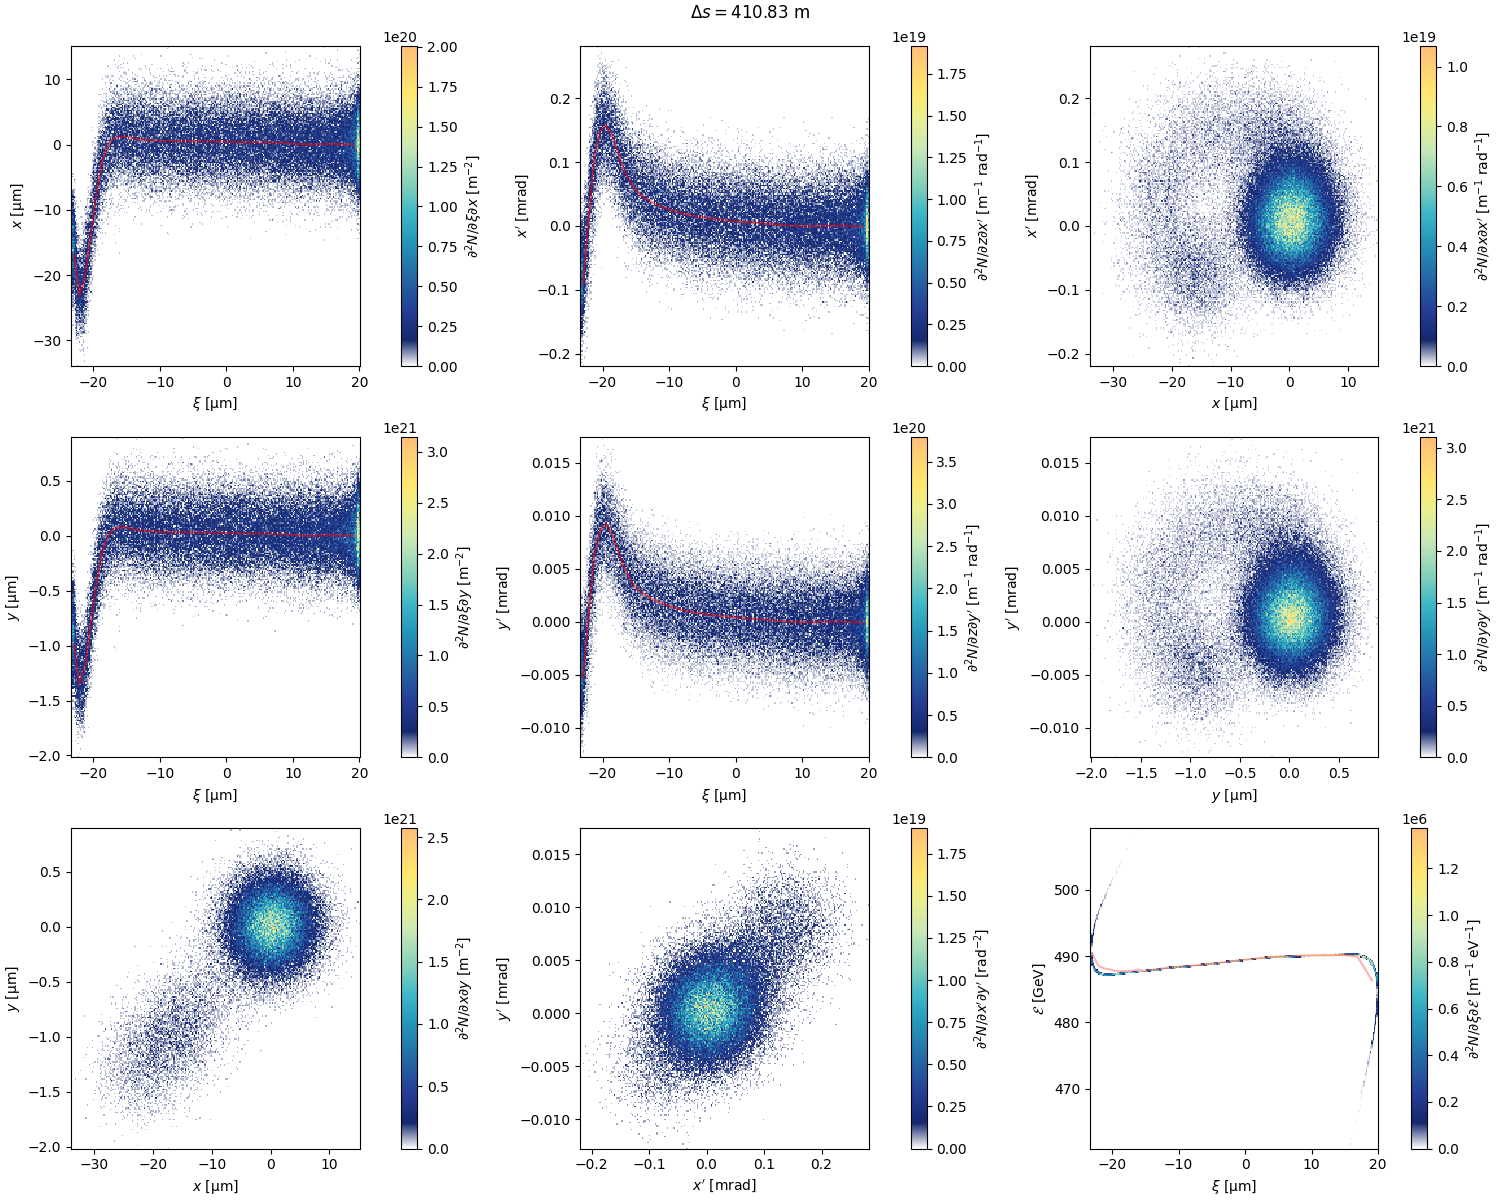

In [15]:
stage_tracked.density_map_diags(beam=beam_out, plot_centroids=True)

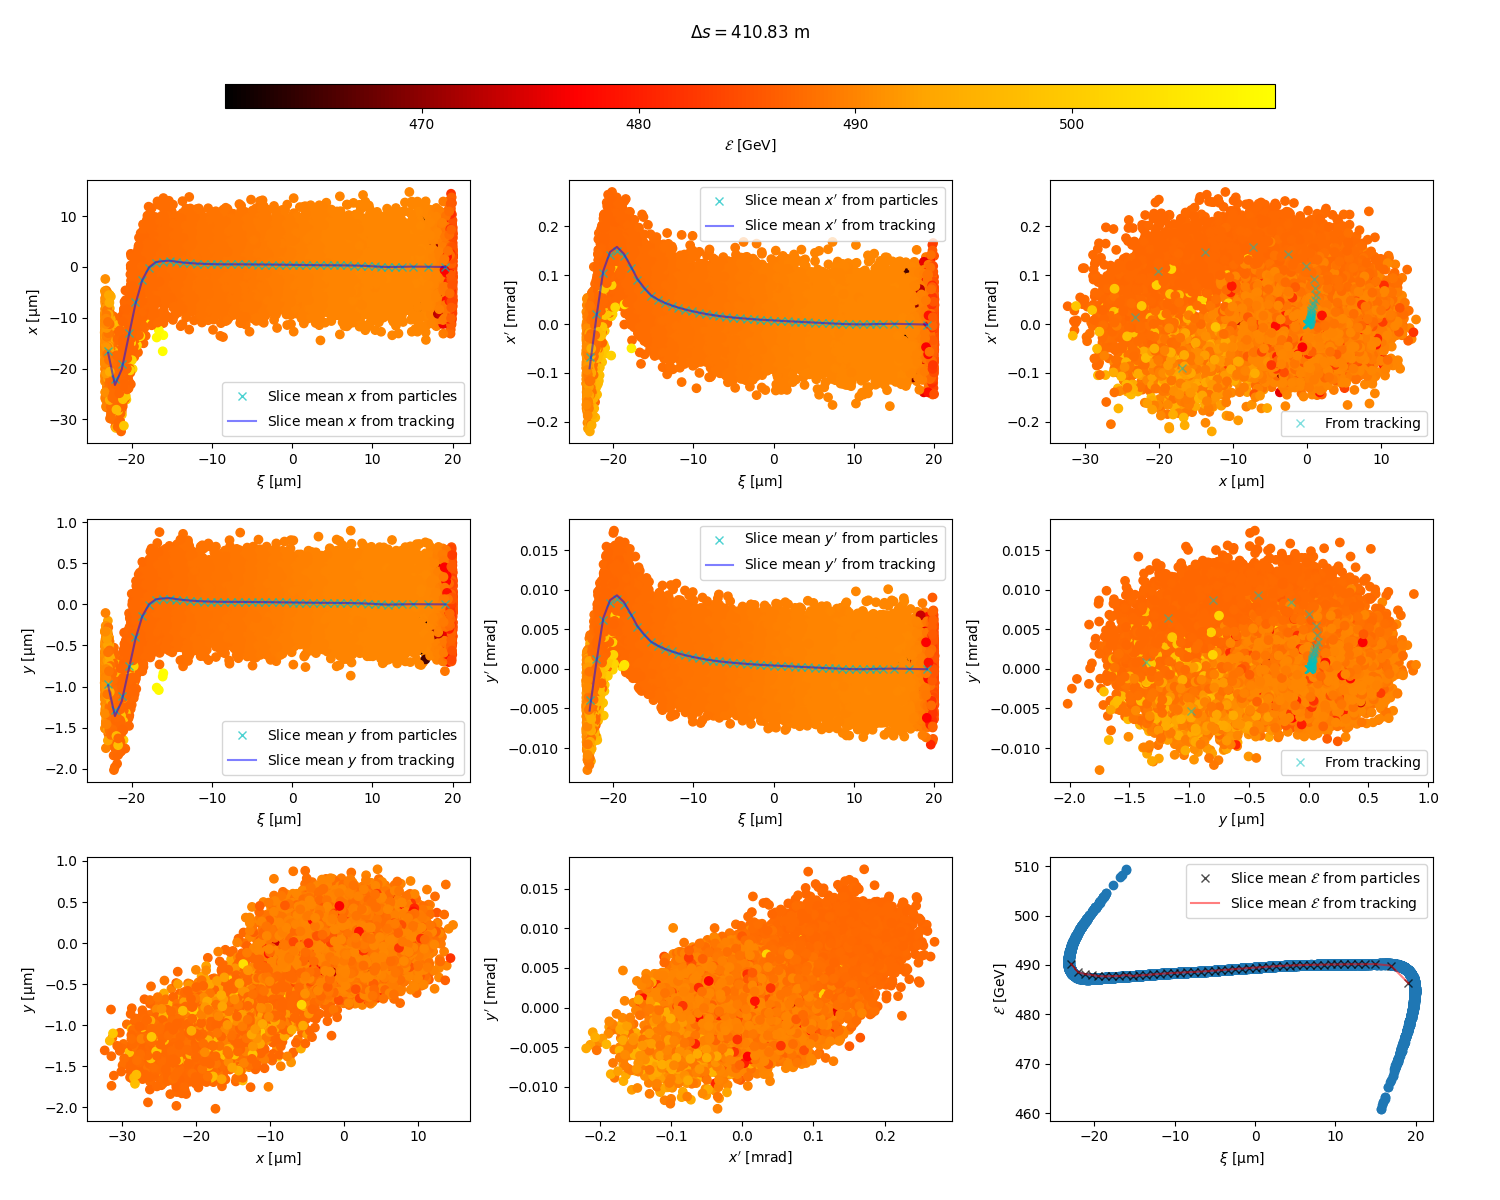

In [16]:
stage_tracked.scatter_diags(beam=beam_out, plot_centroids=True, n_th_particle=3, show_slice_grid=False, plot_k_beta=False)

## Plot beam evolution and survey

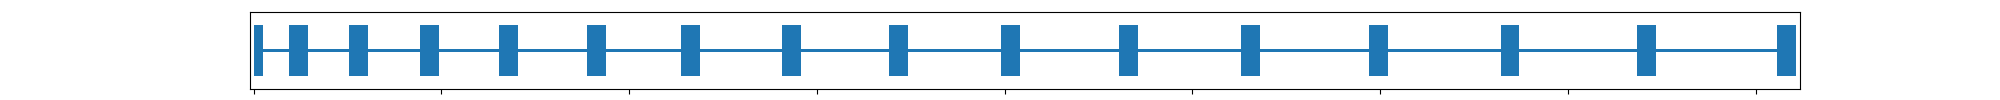

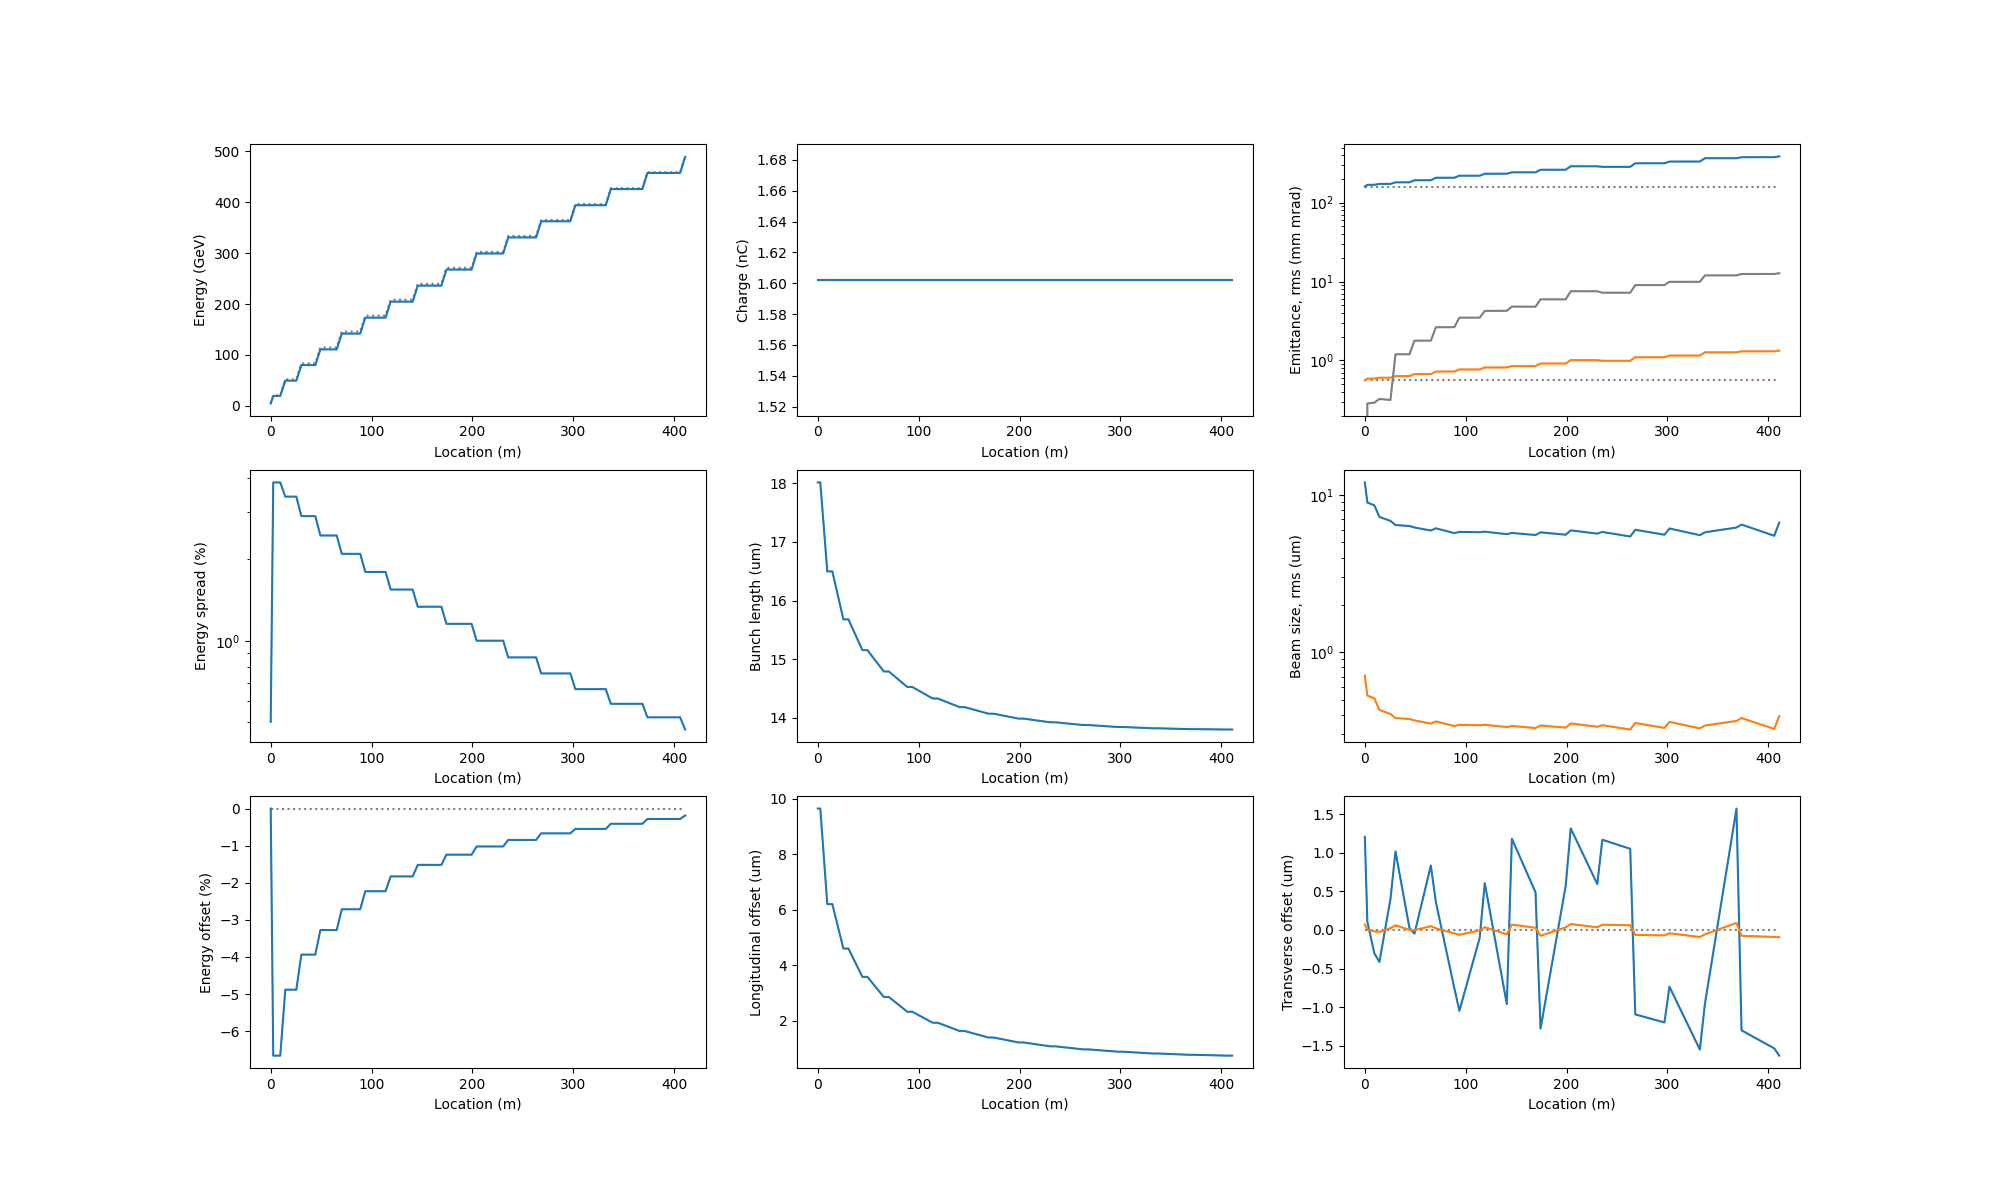

In [17]:
# plot linac survey
linac.plot_survey()

# plot beam evolution
linac.plot_evolution()

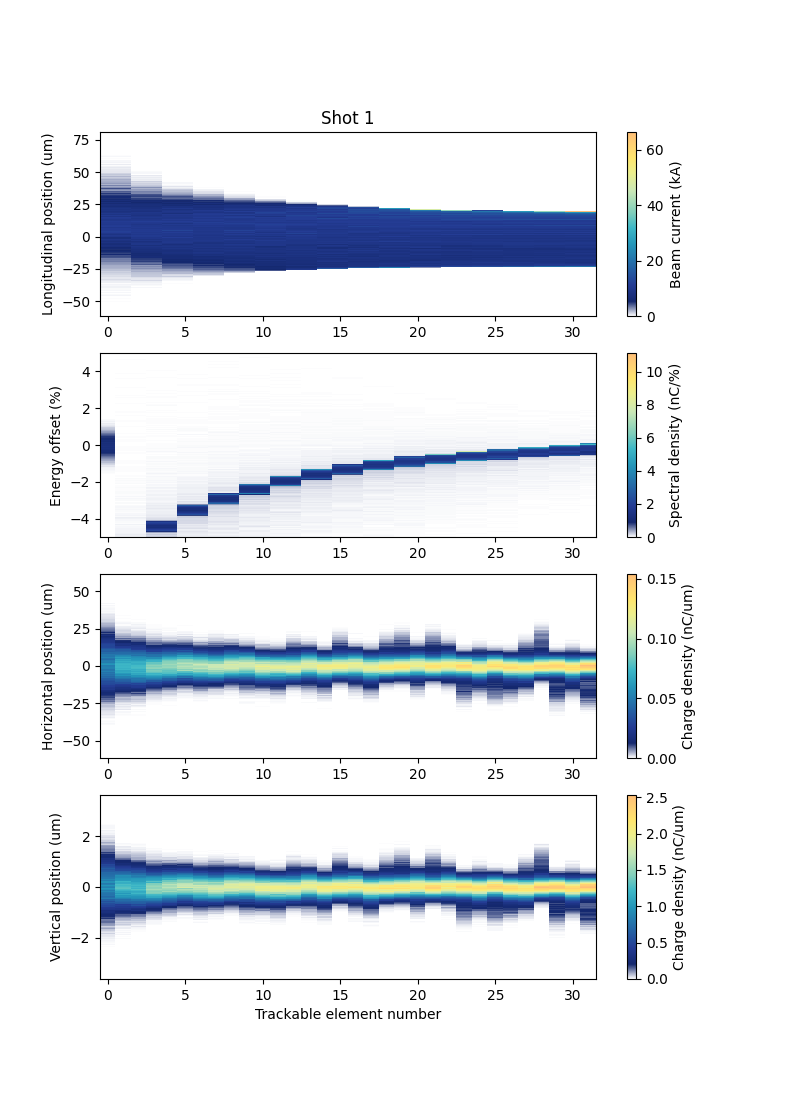

In [20]:
linac.plot_waterfalls()